<a href="https://colab.research.google.com/github/valentinveselcic/OSIRV-Project/blob/main/SU_LV7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sijamsko učenje

Sijamsko učenje (*siamese learning*) je tehnika u strojnom učenju koja koristi paralelne neuronske mreže sa zajedničkim težinama kako bi naučile efikasnu reprezentaciju ulaznih podataka. Osnovna ideja sijamskog učenja je omogućiti mreži učenje sličnosti (*similarity learning*) između parova ulaznih primjera. Primjene uključuju prepoznavanje lica, prepoznavanje otiska prsta, verifikacija potpisa, grupiranje podataka, praćenje objekata u video zapisima itd.

Sijamska mreža sastoji se od dvije identične mreže koje dijele težine. Te mreže primaju različite ulaze te generiraju reprezentacije u nižedimenzionlanom prostori (*embeddings*) za svaki od ulaza. Zatim se mjeri udaljenost između *embeddinga*.

Prilikom treninga mreža treba naučiti generirati takve reprezentacije da je za ulaze iste klase (pozitivni parovi) udaljenost između reprezentacija mala, a za ulaze različitih klasa (negativni parovi) udaljenost između reprezentacija veća.

## Kontrastni gubitak (*constrastive loss*)

Kontrastni gubitak definiran je na sljedeći način:
$$L(x_1, x_2) = y * d(f(x_1), f(x_2))^2 + (1 - y) * max(0, m^2 - d(f(x_1), f(x_2))^2)$$

$y$ je 1 ako su ulazne slike iste klase, 0 inače. $d(f(x_1), f(x_2))$ predstavlja udaljenost između *embeddinga* ulaznih slika. $m$ je proizvoljno odabrana margina, ako nam je kvadrat udaljenosti između reprezentacija negativnih parova veći od $m^2$, vrijednost funkcije gubitka će biti 0.

Za mjeru udaljenosti se može koristiti L2 udaljenost:
$$d(a, b) = \sqrt{\sum_{i=1}^n{(a_i - b_i)^2}}$$

Kako bi udaljenost između reprezentacija bila ograničena, često se reprezentacije normiraju. Na ovaj način će sve reprezentacije biti točke na jediničnoj kružnici. Normiranje vektora:
$$v_{norm} = \frac{v}{||v||_2}$$

## Podatkovni skup

Podatkovni skupovi za primjene za koje se koristi sijamsko učenje često imaju velik broj klasa i mali broj primjera za svaku klasu, stoga bi se nasumičnim odabiranjem parova dobio jako velik broj negativnih parova. Zbog ovoga bi mreža vrlo teško naučila raditi s pozitivnim parovima. Jedan od načina da se ovo riješi je da se generira takav podatkovni skup gdje je podjednak broj pozitivnih i negativnih parova.

U nastavku je implementirano generiranje jednog ovakvog podatkovnog skupa na temelju [Omniglot](https://pytorch.org/vision/main/generated/torchvision.datasets.Omniglot.html) podatkovnog skupa.

In [1]:
## Importing useful libraries
import os
import math
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
from torchsummary import summary

import matplotlib.pyplot as plt
from imageio.v2 import imread
%matplotlib inline

from tqdm.notebook import tqdm

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard

Device cuda


In [2]:
batch_size = 128

In [3]:
import random
from torch.utils.data import DataLoader, Dataset

class MatchedDataset(Dataset):
  def __init__(self, original_dataset):
    self.grouped = {}
    self.size = len(original_dataset)
    for i, c in original_dataset:
      if c not in self.grouped:
        self.grouped[c] = []
      self.grouped[c].append(i)

    self.classes = list(self.grouped.keys())

  def __getitem__(self, index):
    cls0 = random.choice(self.classes)
    image0_idx = random.randint(0, len(self.grouped[cls0]) - 1)
    image0 = self.grouped[cls0][image0_idx]
    ## select random label, 1 for same class, 0 for different class
    label = random.randint(0,1)
    if label:
      ## select a different image of the same class
      while True:
        image1_idx = random.randint(0, len(self.grouped[cls0]) - 1)
        if image0_idx != image1_idx:
          image1 = self.grouped[cls0][image1_idx]
          break
    else:
      ## select a random image from a different class
      while True:
        cls1 = random.choice(self.classes)
        if cls0 != cls1:
          image1 = random.choice(self.grouped[cls1])
          break

    return image0, image1, label

  def __len__(self):
    return self.size

In [4]:
%%capture
import torchvision.transforms as transforms
from torchvision.datasets import Omniglot

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_original_dataset = Omniglot(root='./data/Omniglot', download=True, background=True, transform=img_transform)
train_dataset = MatchedDataset(train_original_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_original_dataset = Omniglot(root='./data/Omniglot', download=True, background=False, transform=img_transform)
test_dataset = MatchedDataset(test_original_dataset)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

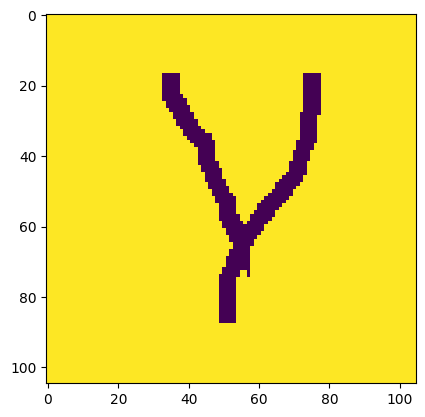

In [8]:
plt.imshow(next(iter(train_dataloader))[0][0].numpy().transpose(1, 2, 0))

## Zadaci

1. Proučite podatkovni skup, prikažite primjere pozitivnih i negativnih parova.

2. Prilagodite neuronsku mrežu iz 3. laboratorijske vježbe kako bi primala dvije slike iz Omniglot podatkovnog skupa i generirala reprezentacije tih ulaza. Za ovo je potrebno izbaciti posljednji, klasifikacijski, sloj te uklonite aktivacijsku funkciju novog posljednjeg sloja. Izlaze iz posljednjeg sloja [normalizirajte](https://pytorch.org/docs/stable/generated/torch.nn.functional.normalize.html).

3. Implementirajte funkciju kontrastnog gubitka.

4. Implementirajte funkciju za treniranje te trenirajte mrežu.

5. Evaluirajte istreniranu mrežu na podacima za testiranje. Funkcija za evaluaciju treba računati točnost, preciznost i odziv. Prilikom evaluacije, potrebno je odabrati prag minimalne udaljenosti za koje će ulazne slike biti klasificirane kao različite. Evaluirajte mrežu s različitim vrijednostima te skicirajte vrijednosti točnosti, preciznosti i odziva u ovisnosti o pragu. Pomoću ove krivulje, odaberite optimalnu vrijednost praga za klasifikaciju.

In [75]:
def contrastive_loss(device, m = 1):
  def loss(embedding1, embedding2, label):
    ## TODO: Implement the contrastive loss
    distance = torch.linalg.norm((embedding1-embedding2), dim = 1)
    loss = torch.mean(label * torch.pow(distance, 2) + (1 - label) * torch.clamp((m ** 2) - torch.pow(distance, 2), min=0))
    return loss
  return loss

In [76]:
loss_module = contrastive_loss(device, 1)

In [77]:
## Check if you implemented the loss correctly, the correct output should be 0.2750

loss_module(torch.Tensor([[1, 1, 1], [0, 1, 1]]).to(device), torch.Tensor([[1, 0.8, 0.9], [0, 0.5, 0.5]]).to(device), torch.Tensor([1, 0]).to(device))

tensor(0.2750, device='cuda:0')

In [78]:
def visualize_results(thresholds, results):
  # thresholds is an array of values of the threshold, e.g. np.arange(0, 2, 0.1)
  # results is an array of shape (len(thresholds), 3) where
  # results[:,0] is the values of accuracy given the different thresholds
  # and results[:,1] and results[:,2] are similarly values of precision and recall

  fig, ax = plt.subplots()
  ax.plot(thresholds, results[:,0], c='green', label='accuracy')
  ax.plot(thresholds, results[:,1], c='blue', label='precision')
  ax.plot(thresholds, results[:,2], c='orange', label='recall')
  plt.legend(loc="lower right")
  plt.show()

In [79]:
def visualize(model, dataloader, n = 6):
  ## visualize some examples of input pairs and the distance between their embeddings
  fig = plt.figure(constrained_layout=True, figsize=(4, 2.2*n))
  subfigs = fig.subfigures(nrows=n, ncols=1)

  for i in range(n):
    data = next(iter(dataloader))
    data_inputs1 = data[0][i].unsqueeze(0)
    data_inputs2 = data[1][i].unsqueeze(0)
    data_labels = data[2][i].unsqueeze(0)

    data_inputs1 = data_inputs1.to(device)
    data_inputs2 = data_inputs2.to(device)
    data_labels = data_labels.to(device)

    embedding1, embedding2 = model((data_inputs1, data_inputs2))
    dist = torch.linalg.norm(embedding1 - embedding2, dim = 1)

    subfig = subfigs[i]
    subfig.suptitle('Distance: %.4f, Label: %d'%(dist, data_labels), size='small')
    ax = subfig.subplots(nrows=1, ncols=2)
    img1_ = data_inputs1[0].cpu().numpy().transpose(1, 2, 0)
    ax[0].imshow(img1_)
    img2_ = data_inputs2[0].cpu().numpy().transpose(1, 2, 0)
    ax[1].imshow(img2_)
  plt.show()

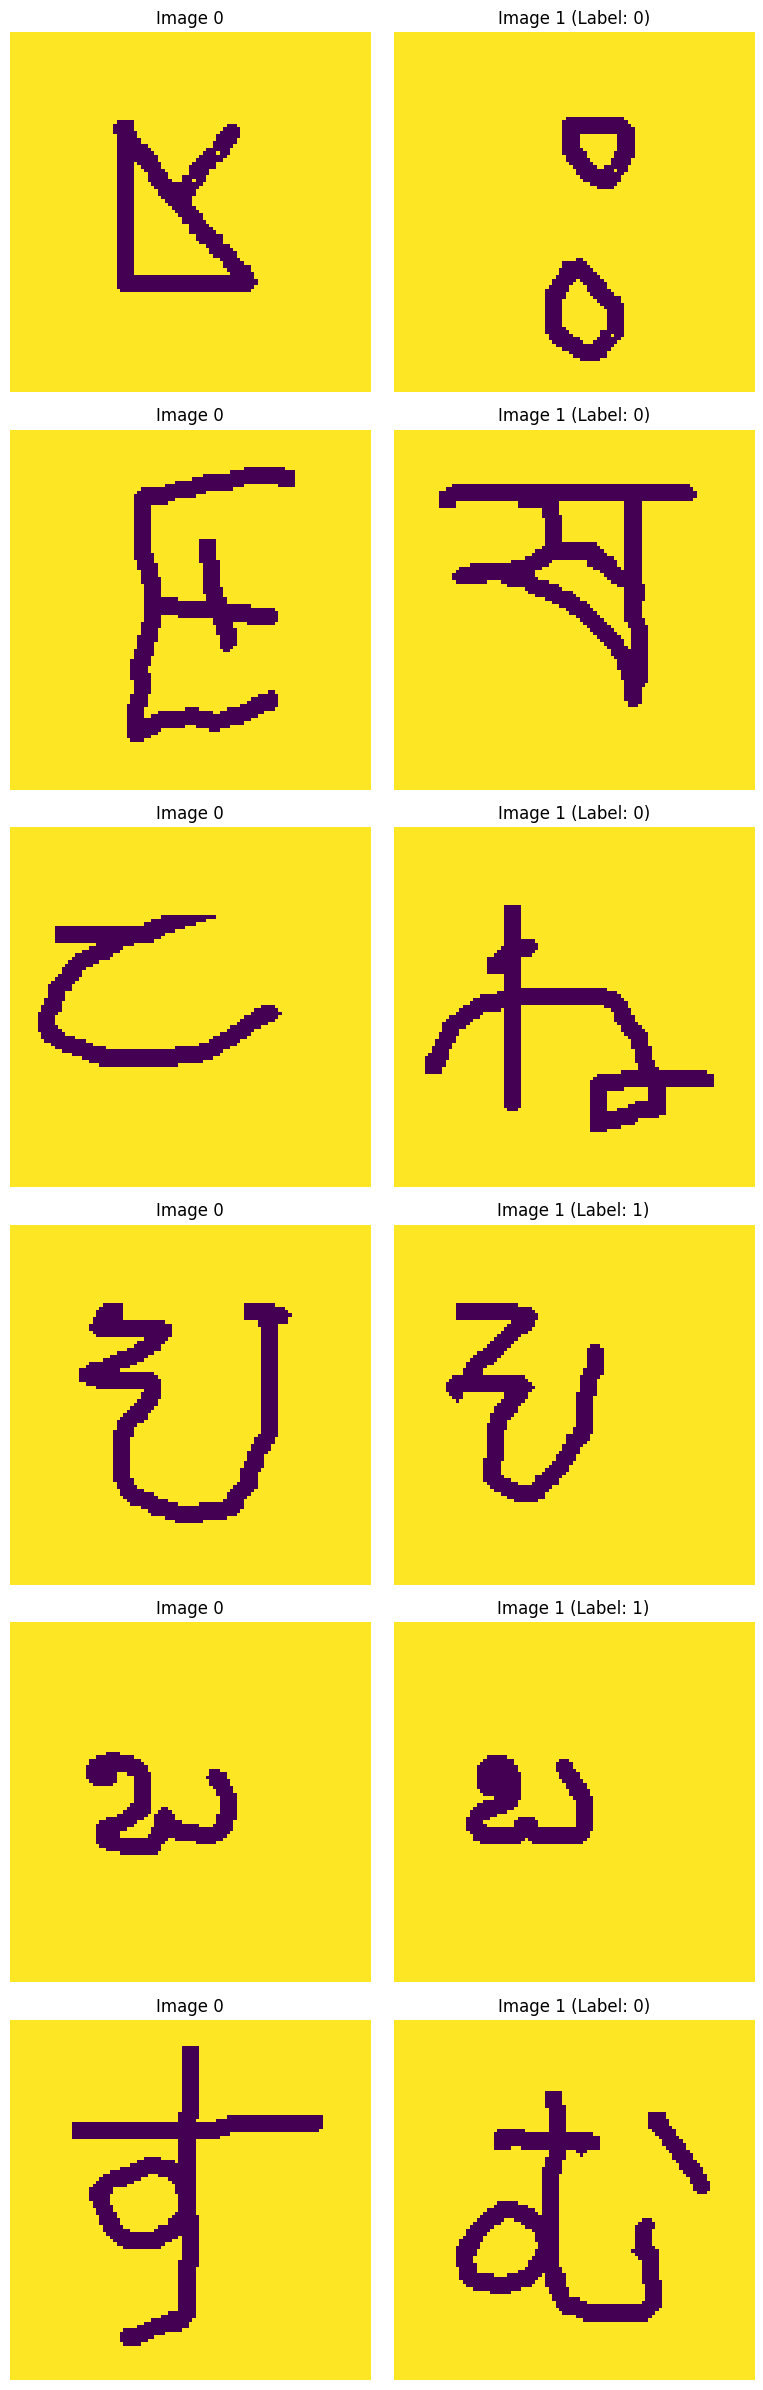

In [85]:

import matplotlib.pyplot as plt

def visualize_pairs(dataloader, n=6):
  """Visualizes positive and negative pairs from the dataloader."""

  fig, axes = plt.subplots(n, 2, figsize=(8, 4 * n))

  for i in range(n):
    image0, image1, label = next(iter(dataloader))
    image0 = image0[i].numpy().transpose(1, 2, 0)
    image1 = image1[i].numpy().transpose(1, 2, 0)

    axes[i, 0].imshow(image0)
    axes[i, 0].set_title(f"Image 0")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(image1)
    axes[i, 1].set_title(f"Image 1 (Label: {label[i]})")
    axes[i, 1].axis('off')

  plt.tight_layout()
  plt.show()


visualize_pairs(train_dataloader)


In [145]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()
        # Initialize the modules we need to build the network
        convolution = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=(3, 3), stride=(1, 1), padding='same')
        convolution1 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=(3, 3), stride=(1, 1), padding='same')
        convolution2 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=(3, 3), stride=(1, 1), padding='same')
        self.conv1 = convolution
        self.batch2d = nn.BatchNorm1d(24)
        self.conv2 = convolution1
        self.conv3 = convolution2
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc1 = nn.Linear(in_features=13*13*48, out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, inputs):
        x, x1 = inputs
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = self.batch2d(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.normalize(x, p=2, dim=1)

        x1 = self.conv1(x1)
        x1 = self.relu(x1)
        x1 = self.pool(x1)
        x1 = self.conv2(x1)
        x1 = self.relu(x1)
        x1 = self.pool(x1)
        x1 = self.conv3(x1)
        x1 = self.relu(x1)
        x1 = self.pool(x1)

        x1 = self.flatten(x1)

        x1 = self.fc1(x1)
        x1 = self.batch2d(x1)
        x1 = self.relu(x1)
        x1 = self.fc2(x1)
        x1 = F.normalize(x1, p=2, dim=1)
        return x, x1

In [146]:
model = CNN()
model.to(device)
loss = contrastive_loss(device, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [147]:
def train_model_with_logger(model, optimizer, train_data_loader, loss_module, num_epochs=100, logging_dir='runs/our_experiment'):
    # Set model to train mode
    writer = SummaryWriter(logging_dir)
    model_plotted = False
    model.train()

    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for image0, image1, label in tqdm(train_data_loader, 'Epoch %d'%(epoch + 1)):

            ## Step 1: Move input data to device
            image0 = image0.to(device)
            image1 = image1.to(device)
            label = label.to(device)

            data_inputs = (image0, image1)
            data_labels = label

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)

            ## Step 3: Calculate the loss

            loss = loss_module(preds[0], preds[1], data_labels)

            ## Step 4: Perform backpropagation
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            epoch_loss += loss.item() * len(data_inputs)
        # Add average loss to TensorBoard
        epoch_loss /= len(train_data_loader.dataset)
        print('Epoch %d, Loss: %.4f'%(epoch + 1, epoch_loss))
        writer.add_scalar('Loss/train', epoch_loss, epoch)

In [149]:
train_model_with_logger(model, optimizer, train_dataloader, loss_module=loss, num_epochs=20)

Epoch 1:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 1, Loss: 0.0035


Epoch 2:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 2, Loss: 0.0033


Epoch 3:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0033


Epoch 4:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0033


Epoch 5:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 5, Loss: 0.0033


Epoch 6:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0032


Epoch 7:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0032


Epoch 8:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 8, Loss: 0.0032


Epoch 9:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 9, Loss: 0.0032


Epoch 10:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 10, Loss: 0.0032


Epoch 11:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 11, Loss: 0.0031


Epoch 12:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 12, Loss: 0.0031


Epoch 13:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 13, Loss: 0.0031


Epoch 14:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 14, Loss: 0.0031


Epoch 15:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 15, Loss: 0.0033


Epoch 16:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 16, Loss: 0.0032


Epoch 17:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 17, Loss: 0.0032


Epoch 18:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 18, Loss: 0.0031


Epoch 19:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 19, Loss: 0.0030


Epoch 20:   0%|          | 0/151 [00:00<?, ?it/s]

Epoch 20, Loss: 0.0030


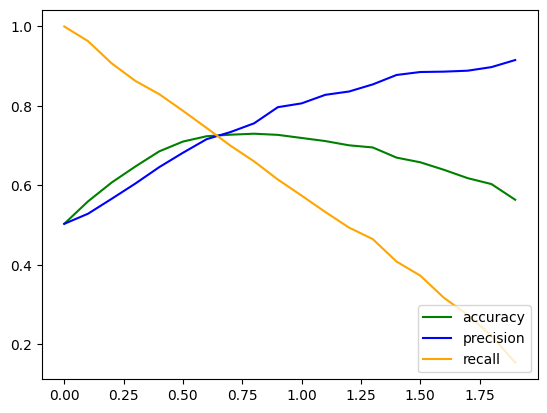

In [150]:

def evaluate_model(model, dataloader, thresholds):
    results = []
    for threshold in thresholds:
        true_positives = 0
        true_negatives = 0
        false_positives = 0
        false_negatives = 0

        with torch.no_grad():
            for image0, image1, label in dataloader:
                image0 = image0.to(device)
                image1 = image1.to(device)
                label = label.to(device)

                embedding1, embedding2 = model((image0, image1))
                distances = torch.linalg.norm(embedding1 - embedding2, dim=1)

                predictions = (distances > threshold).long() # 1 if different, 0 if same

                true_positives += ((predictions == 1) & (label == 0)).sum().item()
                true_negatives += ((predictions == 0) & (label == 1)).sum().item()
                false_positives += ((predictions == 1) & (label == 1)).sum().item()
                false_negatives += ((predictions == 0) & (label == 0)).sum().item()

        accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives) if (true_positives + true_negatives + false_positives + false_negatives) > 0 else 0
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

        results.append([accuracy, precision, recall])
    return np.array(results)

# Example usage
thresholds = np.arange(0, 2, 0.1)
results = evaluate_model(model, test_dataloader, thresholds)

visualize_results(thresholds, results)
